# Classification On Mushroom Dataset

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [84]:
train_path = 'Mushroom_datasets/mushroom_train.csv'
test_path = 'Mushroom_datasets/mushroom_test.csv'

In [85]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42748 entries, 0 to 42747
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          42748 non-null  float64
 1   cap-shape             42748 non-null  object 
 2   cap-surface           42748 non-null  object 
 3   cap-color             42748 non-null  object 
 4   does-bruise-or-bleed  42748 non-null  object 
 5   gill-attachment       42748 non-null  object 
 6   gill-spacing          42748 non-null  object 
 7   gill-color            42748 non-null  object 
 8   stem-height           42748 non-null  float64
 9   stem-width            42748 non-null  float64
 10  stem-color            42748 non-null  object 
 11  has-ring              42748 non-null  object 
 12  ring-type             42748 non-null  object 
 13  habitat               42748 non-null  object 
 14  season                42748 non-null  object 
 15  class              

## Convert string class labels to interger for training. P = 0, E = 1

In [86]:
class_mappings = {'p': 0, 'e': 1}
train_df['class'] = train_df['class'].map(class_mappings)
test_df['class'] = test_df['class'].map(class_mappings)

## Some Data inspection

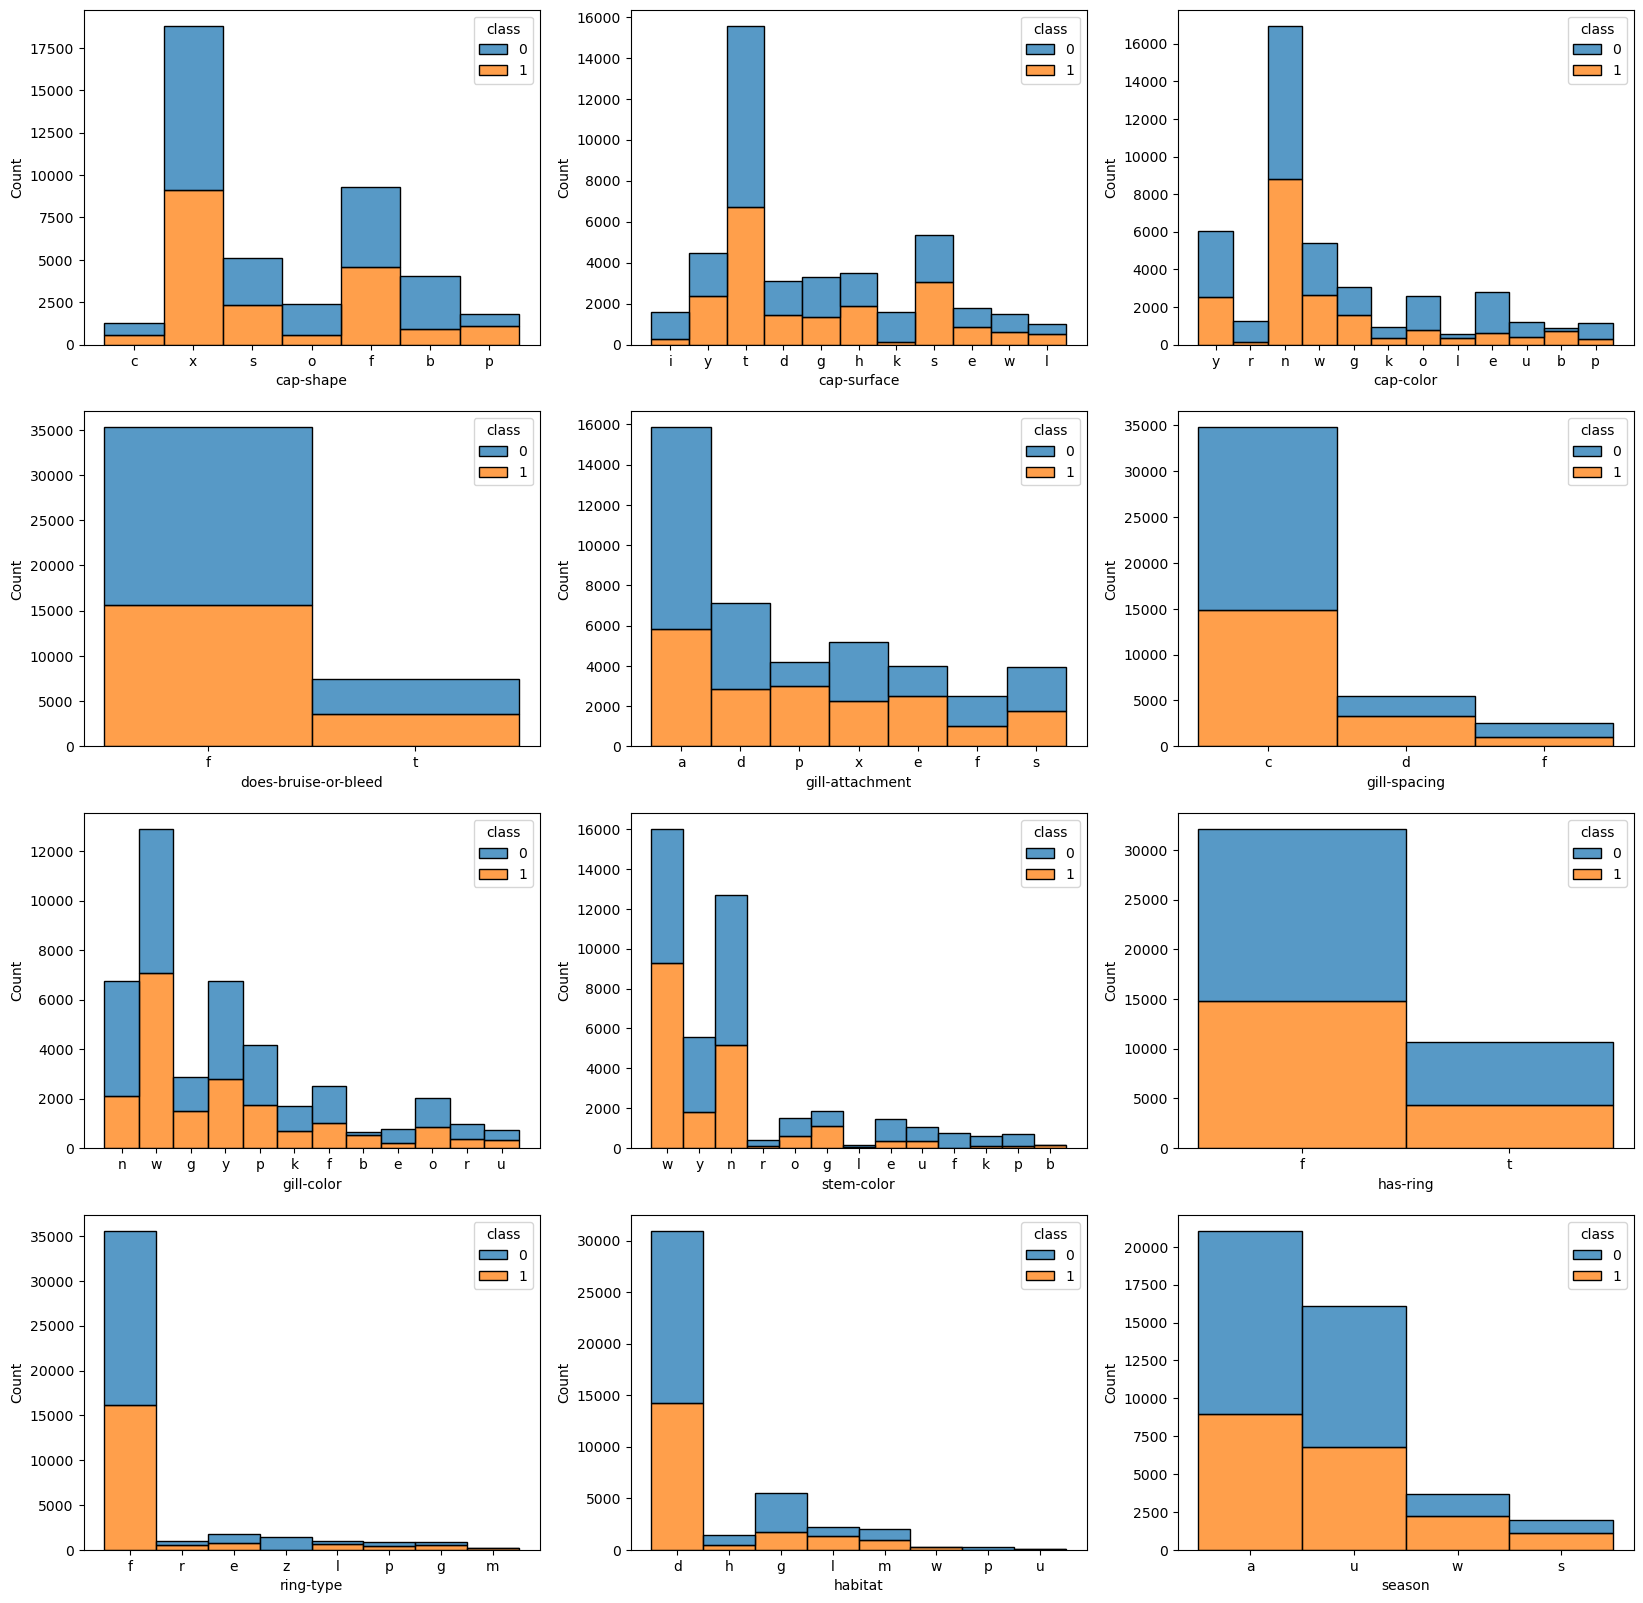

In [87]:
import seaborn as sns
columns_to_visualize = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 'stem-color', 'has-ring','ring-type', 'habitat', 'season']

fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for column in columns_to_visualize:
    sns.histplot(data=train_df, x=column, hue='class', multiple='stack', ax=ax[columns_to_visualize.index(column) // 3, columns_to_visualize.index(column) % 3])

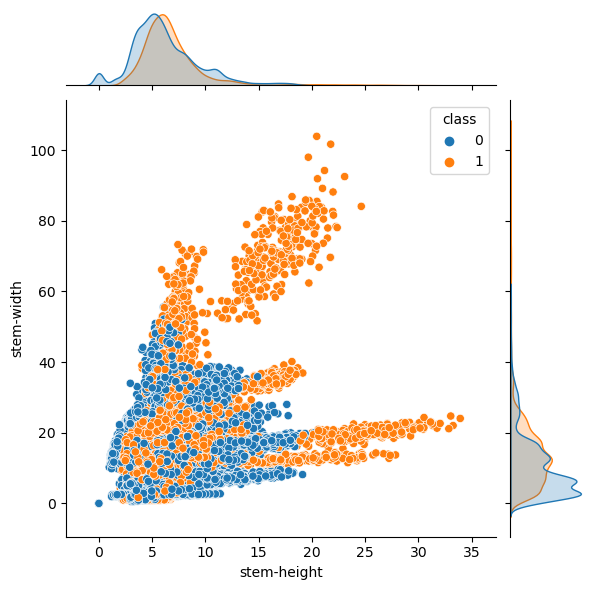

In [88]:
sns.jointplot(x='stem-height', y='stem-width', data=train_df, hue='class')

<Axes: xlabel='cap-diameter', ylabel='Count'>

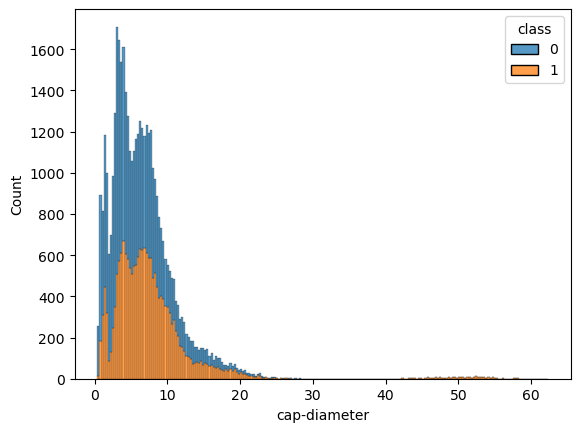

In [89]:
sns.histplot(data=train_df, x='cap-diameter', hue='class', multiple='stack')

#### There are several approach. For clustering models like KNN, GMM, and neural network, we can use approach 1. Convert categorical feature into one-hot feature.

In [90]:
column_to_convert = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 'stem-color', 'has-ring','ring-type', 'habitat', 'season']
for column_name in column_to_convert:
    color_dummies = pd.get_dummies(train_df[column_name], prefix=column_name)
    test_color_dummies = pd.get_dummies(test_df[column_name], prefix=column_name)
    # Concatenate the original DataFrame with the new one-hot encoded columns
    train_df = pd.concat([train_df.drop(column_name, axis=1), color_dummies], axis=1)
    test_df = pd.concat([test_df.drop(column_name, axis=1), test_color_dummies], axis=1)

#### And create x and y using our new feature group

In [91]:
train_x = train_df.drop(['class'], axis=1).to_numpy().astype(np.float32)
train_y = train_df['class'].to_numpy().astype(np.float32)
test_x = test_df.drop(['class'], axis=1).to_numpy().astype(np.float32)
test_y = test_df['class'].to_numpy().astype(np.float32)
train_x.shape, train_y.shape

((42748, 92), (42748,))

## Trivial System: random predictor based on class label distribution

In [73]:
from sklearn.metrics import f1_score

class_0_count = train_df['class'].value_counts()[0]
class_1_count = train_df['class'].value_counts()[1]
print("Class 0 count:", class_0_count, "Class 1 count:", class_1_count)
def trivial_model(n_data):
    return np.random.rand(n_data) > (class_1_count/(class_0_count+class_1_count))

from sklearn.metrics import accuracy_score

n_data = test_y.shape[0]
trivial_pred = trivial_model(n_data)
trivial_train_pred = trivial_model(train_y.shape[0])
print(f"Train Accuracy: {accuracy_score(train_y, trivial_train_pred):4f}")
print(f"Test Accuracy: {accuracy_score(test_y, trivial_pred):4f}")
print(f"F1 score: {f1_score(test_y, trivial_pred):4f}")

Class 0 count: 23595 Class 1 count: 19153
Train Accuracy: 0.496585
Test Accuracy: 0.494951
F1 score: 0.489321


## Base-line system: nearest mean

In [74]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(train_x, train_y)
pred_y = clf.predict(test_x)
train_pred_y = clf.predict(train_x)
print(f"Train Accuracy: {accuracy_score(train_y, train_pred_y):4f}")
print(f"Test Accuracy: {accuracy_score(test_y, pred_y):4f}")
print(f"F1 score: {f1_score(test_y, pred_y):4f}")

Train Accuracy: 0.600496
Test Accuracy: 0.603461
F1 score: 0.536464


## Lets build an Multilayer Perceptron to classify the shroomies.

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define a custom dataset class
class myDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

train_data_torch = torch.from_numpy(train_x)
test_data_torch = torch.from_numpy(test_x)
n_class = 2
train_label_one_hot = np.eye(n_class)[train_y.astype(int)]
test_label_one_hot = np.eye(n_class)[test_y.astype(int)]
train_label_torch = torch.from_numpy(train_label_one_hot.astype(np.float32))
test_label_torch = torch.from_numpy(test_label_one_hot.astype(np.float32))
train_dataset = myDataset(train_data_torch, train_label_torch)
test_dataset = myDataset(test_data_torch, test_label_torch)

N, D = train_data_torch.shape
N, D

trainset, valset = torch.utils.data.random_split(train_dataset, [30000, N-30000])
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}')

# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
        for n_batch, (train_data, labels) in enumerate(trainloader): # Iterate over batches
            train_data, labels = train_data.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(train_data) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels.argmax(1)).float().mean().item()
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
            pbar.update() # Update progress bar
    return running_loss / len(trainloader), running_acc / len(trainloader) # return loss and accuracy for this epoch

# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
            for n_batch, (train_data, labels) in enumerate(valloader): # Iterate over batches
                train_data, labels = train_data.to(device), labels.to(device) # Move batch to device
                output = model(train_data) # Forward pass
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item()
                running_acc += (output.argmax(1) == labels.argmax(1)).float().mean().item()
                pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
                pbar.update() # Update progress bar
    return running_loss / len(valloader), running_acc / len(valloader)  # return loss and accuracy for this epoch

# set the device to use and move model to device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.torch.backends.mps.is_available():
    device = torch.device("mps") # MPS acceleration is available on MacOS 12.3+
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)
    
class MLP(nn.Module):
    def __init__(self, n_feature, n_classes, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(n_feature, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch



Train set size: 30000, Validation set size: 12748
Using device: mps


In [80]:
batchsize = 1000
n_feature = D
output_class = 2
n_hiddens = [4,8,16,32,64]

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

test_accs = []
test_losses = []
test_f1s = []
for n_hidden in n_hiddens:
    print("Model with {} hidden units".format(n_hidden))
    model = MLP(n_feature, output_class, n_hidden).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.02)

    n_epoch = 10
    best_acc = -1
    train_loss_history = []; train_acc_history = []
    val_loss_history = []; val_acc_history = []
    for epoch in range(n_epoch):
        print(f"Epoch {epoch+1}/{n_epoch}")
        train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc     = validate(model, valloader, criterion, device)

        train_loss_history.append(train_loss); train_acc_history.append(train_acc)
        val_loss_history.append(val_loss); val_acc_history.append(val_acc)

    from sklearn.metrics import f1_score


    test_loss, test_acc = validate(model, testloader, criterion, device)
    pred_y = model(test_data_torch.to(device)).argmax(1).cpu().numpy()
    test_f1 = f1_score(test_y, pred_y, average='macro')
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}, Test f1: {test_f1:.4f}")
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    test_f1s.append(test_f1)

Model with 4 hidden units
Epoch 1/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 73.16batch/s, loss=0.464, acc=79.2]


Epoch 2/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 191.38batch/s, loss=0.379, acc=83.3]


Epoch 3/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 195.75batch/s, loss=0.349, acc=86.2]


Epoch 4/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 181.06batch/s, loss=0.33, acc=87.5] 


Epoch 5/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 191.35batch/s, loss=0.322, acc=88.1]


Epoch 6/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 192.15batch/s, loss=0.322, acc=88.1]


Epoch 7/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 193.37batch/s, loss=0.302, acc=89.2]


Epoch 8/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 189.93batch/s, loss=0.302, acc=89.2]


Epoch 9/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 196.89batch/s, loss=0.303, acc=89.9]


Epoch 10/10


Eval: 100%|██████████| 19/19 [00:00<00:00, 214.54batch/s, loss=0.259, acc=89.9]


Test loss: 0.2460, Test acc: 0.8991, Test f1: 0.8962
Model with 8 hidden units
Epoch 1/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 191.35batch/s, loss=0.525, acc=77.7]


Epoch 2/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 193.62batch/s, loss=0.414, acc=84]  


Epoch 3/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 197.18batch/s, loss=0.317, acc=88.9]


Epoch 4/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 193.40batch/s, loss=0.278, acc=91]  


Epoch 5/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 187.05batch/s, loss=0.249, acc=92.2]


Epoch 6/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 194.23batch/s, loss=0.232, acc=93]  


Epoch 7/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 194.18batch/s, loss=0.222, acc=92.7]


Epoch 8/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 192.11batch/s, loss=0.225, acc=93.6]


Epoch 9/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 199.21batch/s, loss=0.212, acc=93.8]


Epoch 10/10


Eval: 100%|██████████| 19/19 [00:00<00:00, 182.95batch/s, loss=0.199, acc=93.8]


Test loss: 0.1757, Test acc: 0.9384, Test f1: 0.9382
Model with 16 hidden units
Epoch 1/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 181.33batch/s, loss=0.473, acc=76.9]


Epoch 2/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 193.90batch/s, loss=0.375, acc=84.7]


Epoch 3/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 197.14batch/s, loss=0.286, acc=89.7]


Epoch 4/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 194.49batch/s, loss=0.219, acc=92.8]


Epoch 5/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 194.06batch/s, loss=0.193, acc=93.4]


Epoch 6/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 197.65batch/s, loss=0.155, acc=95.1]


Epoch 7/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 188.47batch/s, loss=0.128, acc=95.6]


Epoch 8/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 194.86batch/s, loss=0.123, acc=96.1]


Epoch 9/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 189.87batch/s, loss=0.1, acc=96.9]  


Epoch 10/10


Eval: 100%|██████████| 19/19 [00:00<00:00, 213.10batch/s, loss=0.087, acc=97.2] 


Test loss: 0.0837, Test acc: 0.9721, Test f1: 0.9713
Model with 32 hidden units
Epoch 1/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 202.93batch/s, loss=0.404, acc=81.8]


Epoch 2/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 180.74batch/s, loss=0.22, acc=92.8] 


Epoch 3/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 184.17batch/s, loss=0.146, acc=95.5]


Epoch 4/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 196.68batch/s, loss=0.0851, acc=97.7]


Epoch 5/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 197.43batch/s, loss=0.0649, acc=98.4]


Epoch 6/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 195.37batch/s, loss=0.0464, acc=98.8]


Epoch 7/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 197.22batch/s, loss=0.0324, acc=99.2]


Epoch 8/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 193.53batch/s, loss=0.0239, acc=99.5]


Epoch 9/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 181.25batch/s, loss=0.0195, acc=99.7]


Epoch 10/10


Eval: 100%|██████████| 19/19 [00:00<00:00, 211.73batch/s, loss=0.0176, acc=99.7]


Test loss: 0.0157, Test acc: 0.9969, Test f1: 0.9968
Model with 64 hidden units
Epoch 1/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 195.95batch/s, loss=0.318, acc=87.1]


Epoch 2/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 181.54batch/s, loss=0.124, acc=96.7]


Epoch 3/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 164.34batch/s, loss=0.0574, acc=98.7]


Epoch 4/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 189.07batch/s, loss=0.0302, acc=99.5]


Epoch 5/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 188.69batch/s, loss=0.0173, acc=99.8]


Epoch 6/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 167.03batch/s, loss=0.0117, acc=99.9]


Epoch 7/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 193.15batch/s, loss=0.00759, acc=99.9]


Epoch 8/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 195.25batch/s, loss=0.00667, acc=99.9]


Epoch 9/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 178.54batch/s, loss=0.00524, acc=100] 


Epoch 10/10


Eval: 100%|██████████| 19/19 [00:00<00:00, 154.00batch/s, loss=0.00557, acc=99.9]


Test loss: 0.0070, Test acc: 0.9986, Test f1: 0.9985


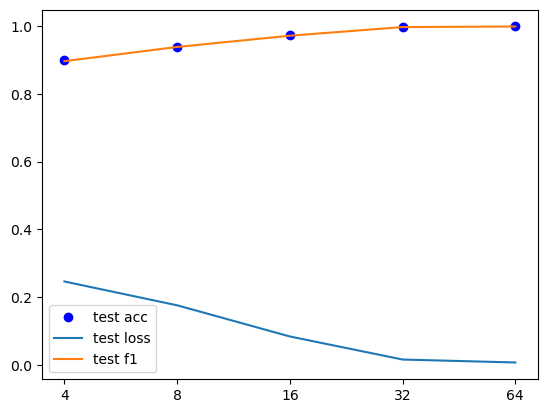

In [82]:
import matplotlib.pyplot as plt
n_point = len(n_hiddens)
plt.plot(np.arange(n_point), test_accs, 'bo', label='test acc')
plt.plot(np.arange(n_point), test_losses, label='test loss')
plt.plot(np.arange(n_point), test_f1s, label='test f1')

plt.xticks(np.arange(n_point), n_hiddens)
plt.legend()
plt.show()

With less than 2% accuracy drop, the least number of hidden nodes needed is 8.

## What about a linear classifier?

In [52]:
batchsize = 1000
n_feature = D
output_class = 2
n_hidden = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

model = LinearRegression(n_feature, output_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

n_epoch = 10
best_acc = -1
train_loss_history = []; train_acc_history = []
val_loss_history = []; val_acc_history = []
for epoch in range(n_epoch):
    print(f"Epoch {epoch+1}/{n_epoch}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc     = validate(model, valloader, criterion, device)

    train_loss_history.append(train_loss); train_acc_history.append(train_acc)
    val_loss_history.append(val_loss); val_acc_history.append(val_acc)

Epoch 1/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 201.16batch/s, loss=0.531, acc=74.6]


Epoch 2/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 211.79batch/s, loss=0.505, acc=76.3]


Epoch 3/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 189.78batch/s, loss=0.503, acc=78.1]


Epoch 4/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 200.48batch/s, loss=0.496, acc=78]  


Epoch 5/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 207.07batch/s, loss=0.494, acc=77.7]


Epoch 6/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 190.87batch/s, loss=0.492, acc=77.7]


Epoch 7/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 199.36batch/s, loss=0.499, acc=75.9]


Epoch 8/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 196.97batch/s, loss=0.492, acc=77.4]


Epoch 9/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 201.36batch/s, loss=0.497, acc=78.5]


Epoch 10/10


Eval: 100%|██████████| 13/13 [00:00<00:00, 202.09batch/s, loss=0.489, acc=77.9]


In [53]:
from sklearn.metrics import f1_score


test_loss, test_acc = validate(model, testloader, criterion, device)
pred_y = model(test_data_torch.to(device)).argmax(1).cpu().numpy()
test_f1 = f1_score(test_y, pred_y, average='macro')
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}, Test f1: {test_f1:.4f}")

Eval: 100%|██████████| 19/19 [00:00<00:00, 182.31batch/s, loss=0.437, acc=77.7]

Test loss: 0.4681, Test acc: 0.7774, Test f1: 0.7740


#### It looks like MLP has very good performance, nearly 100% accuracy. While linear regression performs OK, score around 78%, which is higher than the base-line.

## Classification Using Gaussian Mixture Model

In [54]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

unique_classes = np.unique(train_y)
gmm_models = []

for cls in unique_classes:
    gmm = GaussianMixture(n_components=92, covariance_type='full', random_state=42)
    gmm.fit(train_x[train_y == cls])
    gmm_models.append(gmm)

def predict_gmm_class(X, gmm_models, unique_classes):
    scores = np.array([gmm.score_samples(X) for gmm in gmm_models]).T
    return unique_classes[np.argmax(scores, axis=1)]

y_pred_train = predict_gmm_class(train_x, gmm_models, unique_classes)
y_pred_test = predict_gmm_class(test_x, gmm_models, unique_classes)

train_accuracy = accuracy_score(train_y, y_pred_train)
test_accuracy = accuracy_score(test_y, y_pred_test)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")
f1 = f1_score(test_y, y_pred_test, average='macro')
print(f"Test f1: {f1:.4f}")

Training accuracy: 0.9967
Testing accuracy: 0.9962
Test f1: 0.9961


## GMM has excellent performance as well, close to 100%. But the training time is extended compare to LR or MLP.

#### One reason is that for LR and MLP, we trained it on apple silicon M2 max, while sklearn's mixture model only supports CPU training.

## Another non-probablistic approach is KNN, we think this will performe great as well, just like NN and GMM.

In [83]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

knn = KNeighborsClassifier(n_neighbors=3)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_accuracies = []
test_accuracies = []
f1_scores = []

for train_index, test_index in kf.split(train_x):
    x_train_fold, x_test_fold = train_x[train_index], train_x[test_index]
    y_train_fold, y_test_fold = train_y[train_index], train_y[test_index]

    knn.fit(x_train_fold, y_train_fold)

    y_pred = knn.predict(x_train_fold)
    train_accuracy = accuracy_score(y_train_fold, y_pred)
    train_accuracies.append(train_accuracy)

    test_y_pred = knn.predict(x_test_fold)
    test_accuracy = accuracy_score(y_test_fold, test_y_pred)
    test_accuracies.append(test_accuracy)

    f1 = f1_score(y_test_fold, test_y_pred, average='macro')
    f1_scores.append(f1)

avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
avg_f1_score = np.mean(f1_scores)

std_train_accuracy = np.std(train_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"Average Train Accuracy: {avg_train_accuracy:.4f} (±{std_train_accuracy:.4f})")
print(f"Average Test Accuracy: {avg_test_accuracy:.4f} (±{std_test_accuracy:.4f})")
print(f"Average F1 score: {avg_f1_score:.4f}")


Average Train Accuracy: 0.9997 (±0.0001)
Average Test Accuracy: 0.9990 (±0.0004)
Average F1 score: 0.9990


## Close to 100% which is great. But not as good as an NN, but consider how simple this model is, this is still very impressive.

## After some experiment with SVMs, the result weren't great with the data preprocessing(one-hot encoding for categorical data), so we decided to try some feature engineering.

In [93]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
class_mappings = {'p': 0, 'e': 1}
train_df['class'] = train_df['class'].map(class_mappings)
test_df['class'] = test_df['class'].map(class_mappings)

In [94]:
categorical_columns = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 'stem-color', 'has-ring','ring-type', 'habitat', 'season']
numerical_columns = ['cap-diameter', 'stem-height', 'stem-width']

# Group by the categorical columns and calculate the mean values for the numerical columns
mean_values_df = train_df.groupby(categorical_columns, as_index=False)[numerical_columns].mean()
mean_values_df_test = test_df.groupby(categorical_columns, as_index=False)[numerical_columns].mean()
min_value_df = train_df.groupby(categorical_columns, as_index=False)[numerical_columns].min()
min_value_df_test = test_df.groupby(categorical_columns, as_index=False)[numerical_columns].min()
max_value_df = train_df.groupby(categorical_columns, as_index=False)[numerical_columns].max()
max_value_df_test = test_df.groupby(categorical_columns, as_index=False)[numerical_columns].max()
median_value_df = train_df.groupby(categorical_columns, as_index=False)[numerical_columns].median()
median_value_df_test = test_df.groupby(categorical_columns, as_index=False)[numerical_columns].median()
# Rename the mean columns
mean_values_df.rename(columns={
    'cap-diameter': 'cap-diameter-mean',
    'stem-height': 'stem-height-mean',
    'stem-width': 'stem-width-mean'
}, inplace=True)
mean_values_df_test.rename(columns={
    'cap-diameter': 'cap-diameter-mean',
    'stem-height': 'stem-height-mean',
    'stem-width': 'stem-width-mean'
}, inplace=True)
min_value_df.rename(columns={
    'cap-diameter': 'cap-diameter-min',
    'stem-height': 'stem-height-min',
    'stem-width': 'stem-width-min'
}, inplace=True)
min_value_df_test.rename(columns={
    'cap-diameter': 'cap-diameter-min',
    'stem-height': 'stem-height-min',
    'stem-width': 'stem-width-min'
}, inplace=True)
max_value_df.rename(columns={
    'cap-diameter': 'cap-diameter-max',
    'stem-height': 'stem-height-max',
    'stem-width': 'stem-width-max'
}, inplace=True)
max_value_df_test.rename(columns={
    'cap-diameter': 'cap-diameter-max',
    'stem-height': 'stem-height-max',
    'stem-width': 'stem-width-max'
}, inplace=True)
median_value_df.rename(columns={
    'cap-diameter': 'cap-diameter-median',
    'stem-height': 'stem-height-median',
    'stem-width': 'stem-width-median'
}, inplace=True)
median_value_df_test.rename(columns={
    'cap-diameter': 'cap-diameter-median',
    'stem-height': 'stem-height-median',
    'stem-width': 'stem-width-median'
}, inplace=True)


# Merge the mean values back to the original DataFrame
train_df = train_df.merge(mean_values_df, on=categorical_columns, how='left')
train_df = train_df.merge(min_value_df, on=categorical_columns, how='left')
train_df = train_df.merge(max_value_df, on=categorical_columns, how='left')
train_df = train_df.merge(median_value_df, on=categorical_columns, how='left')
test_df = test_df.merge(min_value_df_test, on=categorical_columns, how='left')
test_df = test_df.merge(max_value_df_test, on=categorical_columns, how='left')
test_df = test_df.merge(mean_values_df_test, on=categorical_columns, how='left')
test_df = test_df.merge(median_value_df_test, on=categorical_columns, how='left')
# Check the updated train_df
train_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-width-mean,cap-diameter-min,stem-height-min,stem-width-min,cap-diameter-max,stem-height-max,stem-width-max,cap-diameter-median,stem-height-median,stem-width-median
0,4.98,c,i,y,f,a,c,n,6.04,6.21,...,7.613750,3.41,5.40,5.92,6.70,7.73,10.03,4.980,6.475,7.395
1,2.84,x,y,y,f,a,c,w,5.66,3.55,...,3.539231,2.84,5.07,3.40,4.47,6.24,3.72,3.770,5.540,3.530
2,11.44,x,y,y,f,a,c,w,7.03,25.29,...,24.623704,6.68,4.41,20.83,12.99,8.81,27.22,9.450,6.600,25.180
3,8.77,s,t,r,t,d,c,g,4.44,13.61,...,12.993333,6.58,4.29,10.66,8.81,4.77,14.38,8.185,4.555,13.660
4,7.55,x,d,n,t,p,c,y,8.41,18.44,...,14.683626,3.50,3.80,10.83,9.97,10.15,18.44,6.710,6.920,14.710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42743,3.28,f,y,p,f,e,c,n,4.96,3.51,...,3.395000,2.71,4.09,3.22,3.42,4.96,3.55,3.120,4.230,3.405
42744,8.91,x,w,p,f,s,c,p,4.61,11.12,...,9.925098,5.73,3.18,8.55,9.10,5.86,11.83,7.400,4.310,10.010
42745,45.84,o,y,y,f,p,c,y,5.75,26.36,...,36.226667,39.76,3.65,18.75,57.98,9.13,50.40,51.375,6.570,36.380
42746,10.91,f,y,n,f,a,c,w,7.55,24.38,...,25.145200,7.24,5.15,22.14,12.85,8.87,28.46,9.910,6.930,25.500


## Classification Using SVM

In [95]:
train_x = train_df.drop(['class']+categorical_columns, axis=1).to_numpy().astype(np.float32)
train_y = train_df['class'].to_numpy().astype(np.float32)
test_x = test_df.drop(['class']+categorical_columns, axis=1).to_numpy().astype(np.float32)
test_y = test_df['class'].to_numpy().astype(np.float32)
train_x.shape, train_y.shape

((42748, 15), (42748,))

In [96]:
# normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [97]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')

c_values = np.logspace(-4, 6, num=11)
param_grid = {'C': c_values}

svm = SVC(kernel='rbf', max_iter=100)
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5)
grid_search.fit(train_x, train_y)
y_pred = grid_search.predict(test_x)
accuracy = grid_search.score(test_x, test_y)
train_accuracy = grid_search.score(train_x, train_y)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Tesing accuracy: {accuracy:.4f}")
print(f"F1 score: {f1_score(test_y, y_pred, average='macro'):.4f}")

Training accuracy: 0.6245
Tesing accuracy: 0.6169
F1 score: 0.5957


## This is awful, let's try some ensembles of SVMs.

In [20]:
from sklearn.ensemble import BaggingClassifier



base_estimator = SVC(max_iter=100, C=0.1)

bagging_classifier = BaggingClassifier(base_estimator, n_estimators=20)
bagging_classifier.fit(train_x, train_y)

train_accuracy = bagging_classifier.score(train_x, train_y)
accuracy = bagging_classifier.score(test_x, test_y)
y_pred = bagging_classifier.predict(test_x)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Tesing accuracy: {accuracy:.4f}")
print(f"F1 score: {f1_score(test_y, y_pred, average='macro'):.4f}")

Training accuracy: 0.5520
Tesing accuracy: 0.5618
F1 score: 0.3597


## Still awful.

In [108]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')

svm = SVC(kernel='rbf', C=1000, gamma='scale', max_iter=100)
adaboost = AdaBoostClassifier(base_estimator=svm, n_estimators=4, learning_rate=1, random_state=42, algorithm='SAMME')
adaboost.fit(train_x, train_y)
y_pred = adaboost.predict(test_x)

accuracy = accuracy_score(test_y, y_pred)
y_pred_train = adaboost.predict(train_x)
train_accuracy = accuracy_score(train_y, y_pred_train)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Tesing accuracy: {accuracy:.4f}")
print(f"F1 score: {f1_score(test_y, y_pred, average='macro'):.4f}")

Training accuracy: 0.6245
Tesing accuracy: 0.6169
F1 score: 0.5957


## The adaboost won't even run because the base model is worse than random.